In [ ]:
# mount drive with files

from google.colab import drive
drive.mount('/content/drive')


!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

!pip install SimpleITK


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 33.6 MB/s eta 0:00:00


In [ ]:
# import libraries


from torch.utils.data import DataLoader, ConcatDataset
from SimpleITK.extra import GetArrayFromImage
from SimpleITK import CastImageFilter, HausdorffDistanceImageFilter
import os
import shutil
import tempfile
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

import SimpleITK as sitk

from monai.losses import DiceCELoss, GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    ToTensord,

)



from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import VNet

from monai.data import (
    DataLoader,
    SmartCacheDataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# set dimensions of the input images (128x128x128) and number of classes (number of labels + background)

img_dim=128
lab_num=1
class_num=lab_num+1


degree_min = -1
degree_max = 1


split_JSON = "face-test.json"
split_JSON_run = "face-test.json"

root_dir='/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'
test_dir = '/content/drive/MyDrive/face-seg-project-2023/new-training-062023/face-test-subjects'

print(test_dir)
os.chdir(test_dir)



/content/drive/MyDrive/face-seg-project-2023/new-training-062023/face-test-subjects


In [ ]:
transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

In [ ]:
# load the files based on the lists in .json

datasets = root_dir + split_JSON

test_files = load_decathlon_datalist(datasets, True, "test")

In [ ]:
test_ds = CacheDataset(
    data=test_files,
    transform=transforms,
    cache_num=200,
    cache_rate=1.0,
    num_workers=4,
)


test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Test Set
0 img-1000.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


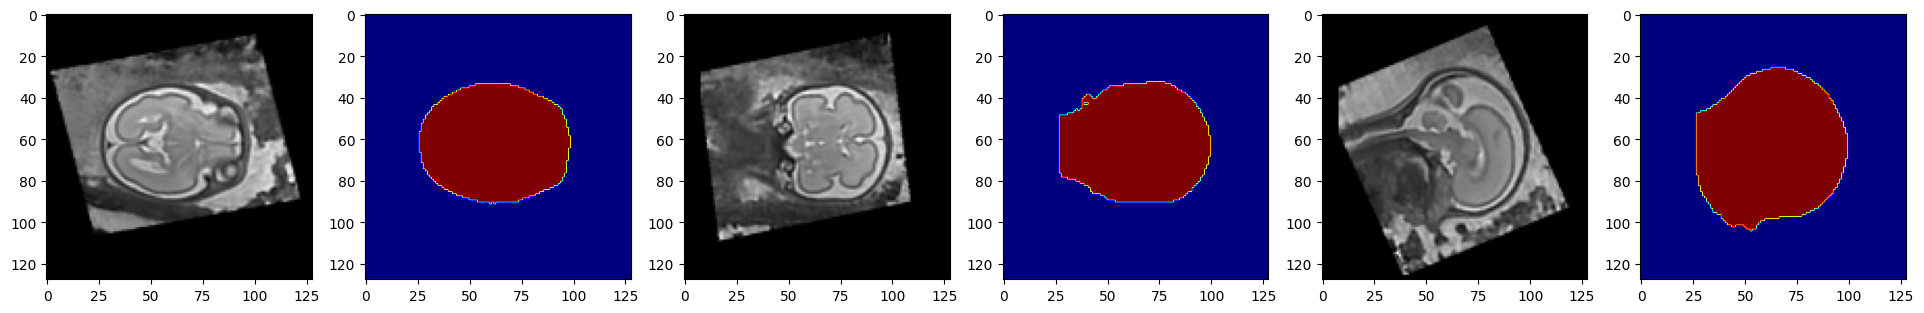

1 img-1001.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


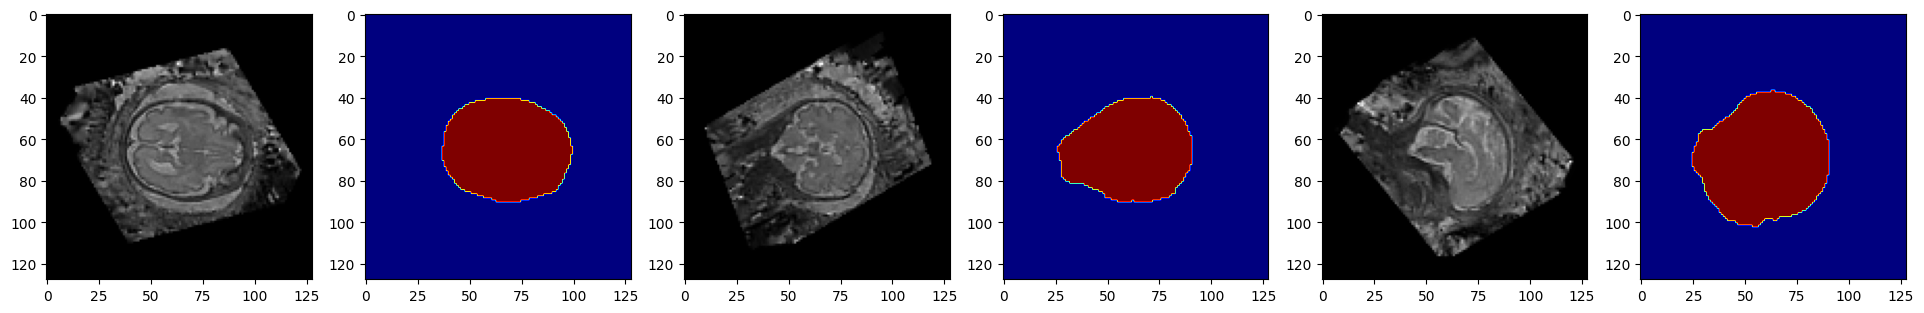

2 img-1002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


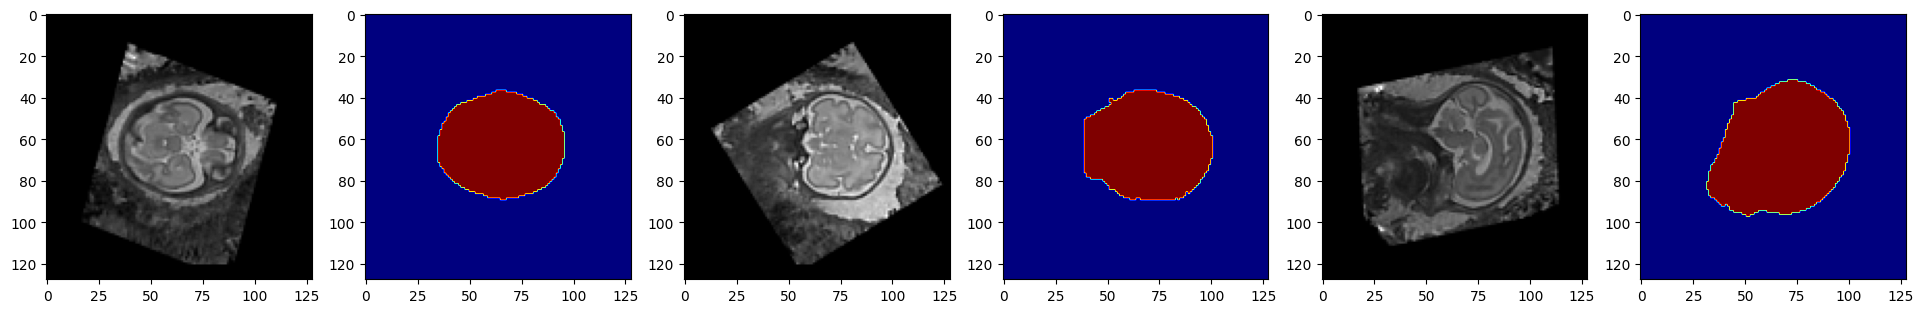

3 img-1003.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


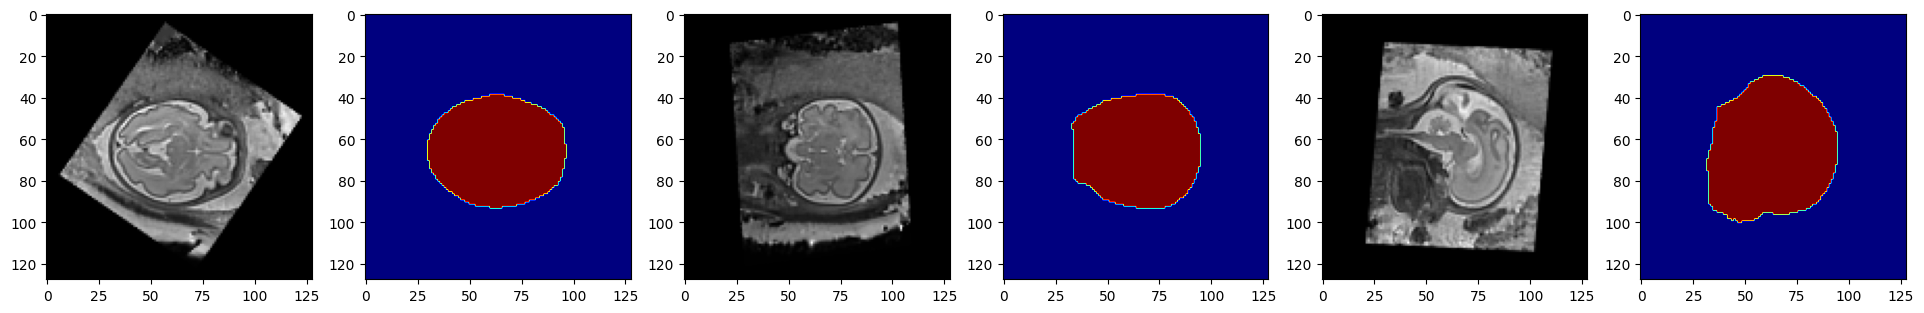

4 img-1004.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


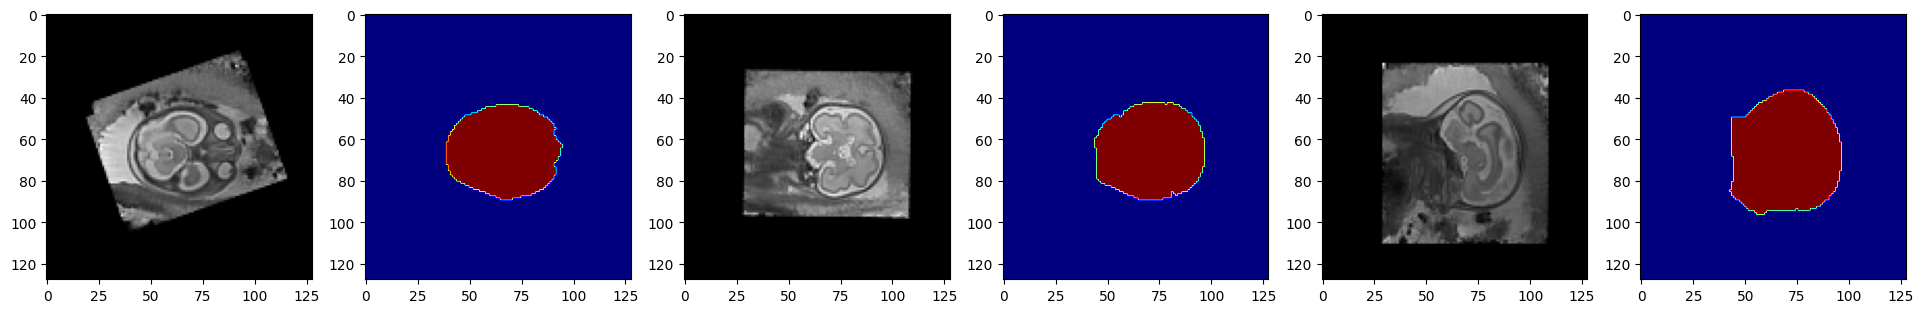

5 img-1005.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


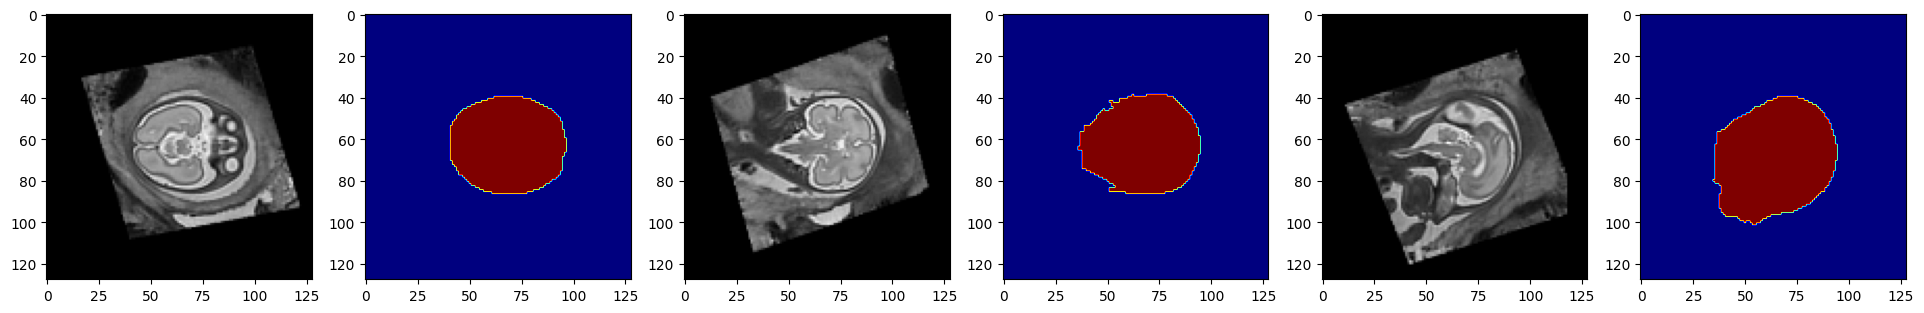

6 img-1006.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


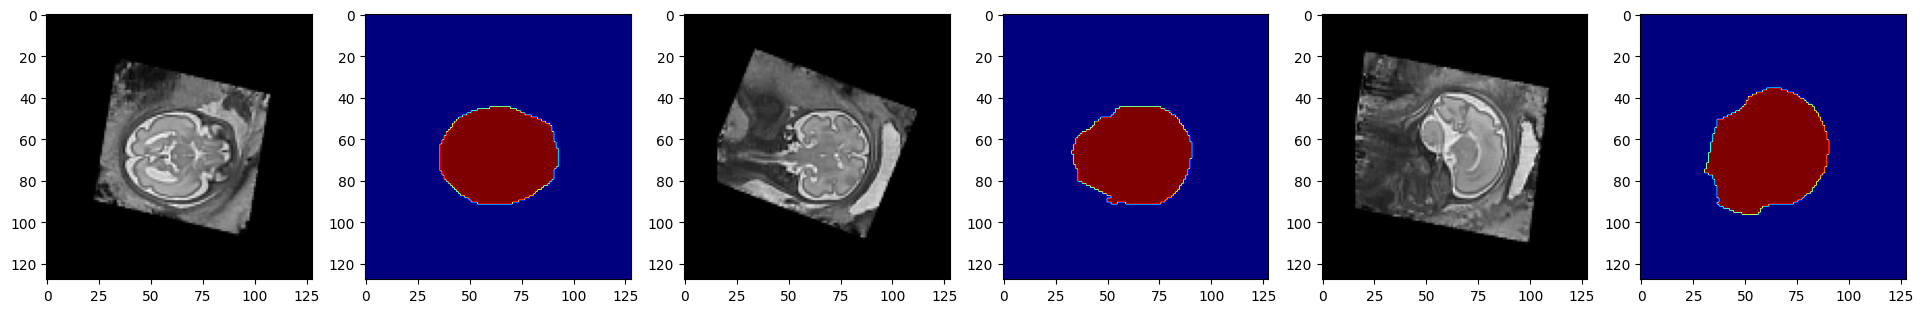

7 img-1007.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


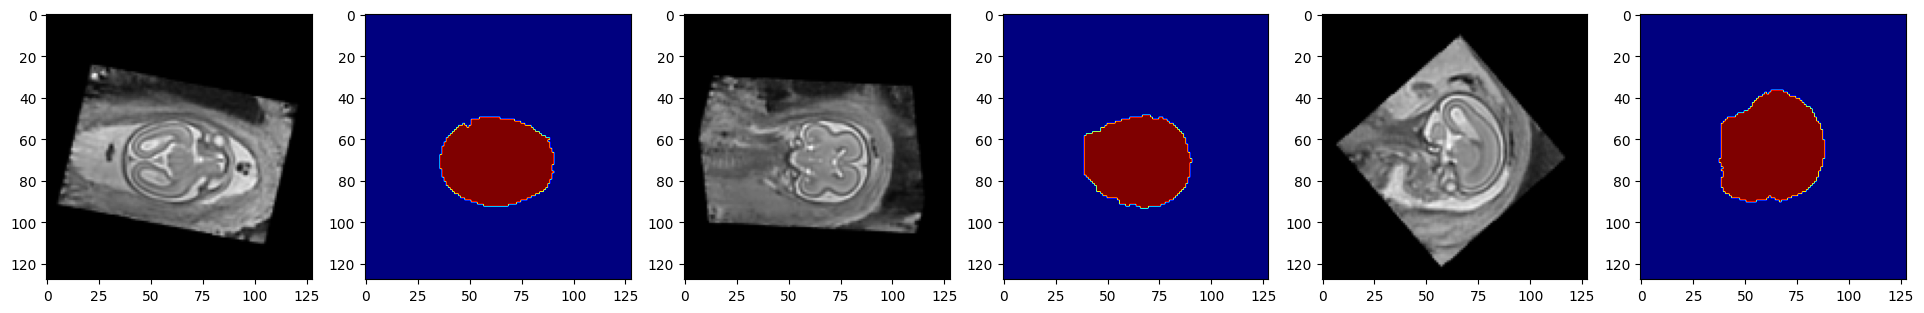

8 img-1008.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


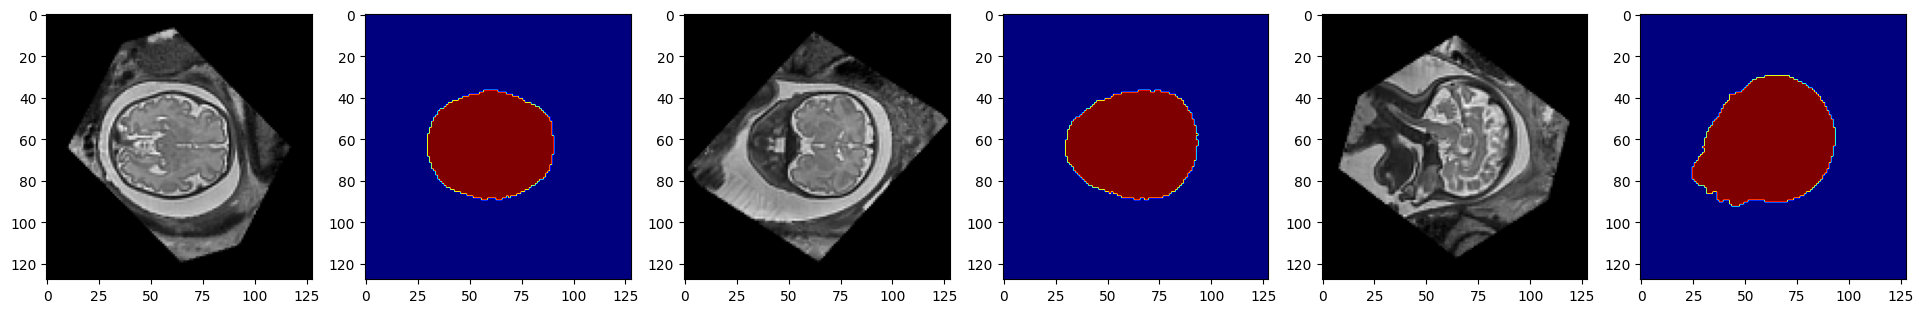

9 img-1009.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


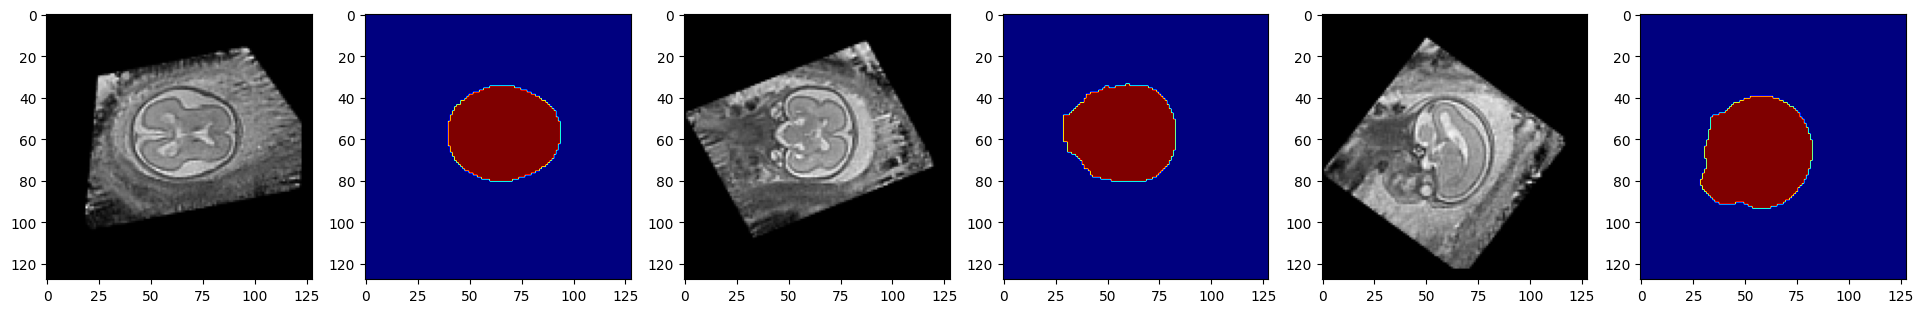

In [ ]:
print("Test Set")
s = round(img_dim / 2)

for x in range(len(test_ds)):
    sample = test_ds[x]
    img = sample["image"]
    label = sample["label"]

    img = sample["image"]
    label = sample["label"]
    case_name = os.path.split(sample["image_meta_dict"]["filename_or_obj"])[1]
    img_shape = img.shape
    label_shape = label.shape

    print(x, case_name, img_shape, label_shape)

    # print(x, case_name, img_shape, label_shape)
    plt.figure("image", (24, 4))
    plt.subplot(1, 6, 1)
    plt.imshow(img[0, :, :, s], cmap="gray")
    plt.subplot(1, 6, 2)
    plt.imshow(label[0, :, :, s], cmap="jet")
    plt.subplot(1, 6, 3)
    plt.imshow(img[0, :, s, :], cmap="gray")
    plt.subplot(1, 6, 4)
    plt.imshow(label[0, :, s, :], cmap="jet")
    plt.subplot(1, 6, 5)
    plt.imshow(img[0, s, :, :], cmap="gray")
    plt.subplot(1, 6, 6)
    plt.imshow(label[0, s, :, :], cmap="jet")
    plt.show()


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define the name of the subdirectory
folder = '3D_vnet_no_aug_test_results_new'

# Create the full path for the new directory
res_dir = os.path.join(root_dir, folder)

# Create the output directory if it doesn't exist
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [ ]:
# Load the model and prepare it for evaluation
#CHANGE PER MODEL
model_path = '/content/drive/MyDrive/face-seg-project-2023/new-training-062023/face_vnet_no_aug_best_metric_model.pth'

class_n=2
qq=round(img_dim/2)

model = VNet(spatial_dims=3, in_channels=1, out_channels=class_num,
             act=('elu', {'inplace': True}),
             dropout_dim=3, bias=False).to(device)


loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

model.load_state_dict(torch.load(model_path))
model.eval()

RuntimeError: ignored

In [ ]:
all_outputs=[]
qq=round(img_dim/2)
class_n=2

for i, batch in enumerate(test_loader):
    with torch.no_grad():
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(images)
        all_outputs.append(outputs)


    for i in range(images.size(0)):
        img_name = os.path.split(batch["image_meta_dict"]["filename_or_obj"][0])[1]  # Get the name of the image
        img_np = images[i].cpu().numpy()[0]  # Get the entire 3D image
        label_np = labels[i].cpu().numpy()[0]  # Get the entire 3D label
        model_output_np = torch.argmax(outputs, dim=1).cpu().numpy()[i]  # Get the entire 3D model output

        # Iterate through axial, coronal, and sagittal views
        for view in range(3):
            if view == 0:
                slice_np = img_np[s, :, :]
                view_label = "Sagittal"
            elif view == 1:
                slice_np = img_np[:, s, :]
                view_label = "Coronal"
            else:
                slice_np = img_np[:, :, s]
                view_label = "Axial"

            # Plot the images side by side with labels
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].set_title(f"{view_label} View - Original Image Slice\n{img_name}")
            axs[0].imshow(slice_np, cmap="gray")

            axs[1].set_title(f"{view_label} View - Actual Label Slice\n{img_name}")
            axs[1].imshow(label_np[s, :, :] if view == 0 else label_np[:, s, :] if view == 1 else label_np[:, :, s], vmin=0, vmax=class_n, cmap="jet")

            axs[2].set_title(f"{view_label} View - Model Output Slice\n{img_name}")
            axs[2].imshow(model_output_np[s, :, :] if view == 0 else model_output_np[:, s, :] if view == 1 else model_output_np[:, :, s], vmin=0, vmax=class_n, cmap="jet")

            plt.show()


            output_name = os.path.splitext(os.path.basename(img_name))[0] + ".gz"  # Create the output filename

            model_output_np = np.moveaxis(model_output_np, [0, 1, 2], [2, 1, 0])

            # Convert the output to a SimpleITK image
            output_sitk = sitk.GetImageFromArray(model_output_np)

            # Get metadata from the input image
            input_image_info = sitk.ReadImage(img_name)
            output_path = os.path.join(res_dir, output_name)
            sitk.WriteImage(output_sitk, output_path)

            print(f"Model output {output_name} saved to:", res_dir)



In [ ]:
# Define the name of the subdirectory
# CHANGE PER MODEL
folder = '3D_vnet_no_aug_test_results_new'

print(len(all_outputs))

# Create the full path for the new directory
res_dir = os.path.join(root_dir, folder)

# Create the output directory if it doesn't exist
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

# Iterate through the batch
for i in range(len(all_outputs)):
    img_name = test_ds[i]["image_meta_dict"]["filename_or_obj"]  # Get the image filename from val_ds_run
    output_name = os.path.splitext(os.path.basename(img_name))[0] + ".gz"  # Create the output filename

    # Get the model output for this image
    model_output_np = all_outputs[i].detach().cpu()
    model_output_np = torch.argmax(model_output_np, dim=1).detach().cpu()[0, :, :, :]
    model_output_np = np.moveaxis(model_output_np, [0, 1, 2], [2, 1, 0])
    print(model_output_np.shape)
    # model_output_np = all_outputs[i].squeeze().cpu().numpy()

    # Convert the output to a SimpleITK image
    output_sitk = sitk.GetImageFromArray(model_output_np)

    # Get metadata from the input image
    input_image_info = sitk.ReadImage(img_name)

    # Save the output to the specified directory
    output_path = os.path.join(res_dir, output_name)
    sitk.WriteImage(output_sitk, output_path)

    print(f"Model output {output_name} saved to:", res_dir)



10
(128, 128, 128)
Model output img-1000.nii.gz saved to: /content/drive/MyDrive/face-seg-project-2023/new-training-062023/3D_vnet_no_aug_test_results_new
(128, 128, 128)
Model output img-1001.nii.gz saved to: /content/drive/MyDrive/face-seg-project-2023/new-training-062023/3D_vnet_no_aug_test_results_new
(128, 128, 128)
Model output img-1002.nii.gz saved to: /content/drive/MyDrive/face-seg-project-2023/new-training-062023/3D_vnet_no_aug_test_results_new
(128, 128, 128)
Model output img-1003.nii.gz saved to: /content/drive/MyDrive/face-seg-project-2023/new-training-062023/3D_vnet_no_aug_test_results_new
(128, 128, 128)
Model output img-1004.nii.gz saved to: /content/drive/MyDrive/face-seg-project-2023/new-training-062023/3D_vnet_no_aug_test_results_new
(128, 128, 128)
Model output img-1005.nii.gz saved to: /content/drive/MyDrive/face-seg-project-2023/new-training-062023/3D_vnet_no_aug_test_results_new
(128, 128, 128)
Model output img-1006.nii.gz saved to: /content/drive/MyDrive/face-se

In [ ]:
#Evaluation metrics functions
# calculate Dice coefficient (takes numpy arrays)
def Dice(pred,gt):
    pred_numpy = sitk.GetArrayFromImage(pred)
    gt_numpy = sitk.GetArrayFromImage(gt)

    #calculate intersection between the predicted and ground truth segmentation masks
    intersection = np.logical_and(pred_numpy, gt_numpy).sum()
    #calculates the union between the predicted and ground truth segmentation masks
    union = np.logical_or(pred_numpy, gt_numpy).sum()
    dice = (2.0 * intersection) / (union + intersection)
    print('Dice Score =',np.round(dice, 6))
    return dice

def Hausdorff(sitk_pred, sitk_gt):
    # Create a reference image with the desired spacing and origin
    reference_spacing = sitk_gt.GetSpacing()
    reference_origin = sitk_gt.GetOrigin()
    reference_size = sitk_gt.GetSize()
    reference_direction = sitk_gt.GetDirection()

    # Resample the predicted image
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(sitk_gt)
    resampler.SetOutputSpacing(reference_spacing)
    resampler.SetSize(reference_size)
    resampler.SetOutputDirection(reference_direction)
    resampler.SetOutputOrigin(reference_origin)
    resampler.SetTransform(sitk.Transform())
    resampled_pred = resampler.Execute(sitk_pred)

    hausdorffcomputer = sitk.HausdorffDistanceImageFilter()
    hausdorffcomputer.Execute(resampled_pred, sitk_gt)
    hd = hausdorffcomputer.GetHausdorffDistance()
    print('Hausdorff distance:', np.around(hd, 2))
    ahd = hausdorffcomputer.GetAverageHausdorffDistance()
    print('Average Hausdorff distance:', np.around(ahd, 2))
    return hd, ahd

def Precision_Recall(pred,gt):
  # Convert SimpleITK images to numpy arrays
  pred_np = sitk.GetArrayFromImage(pred)
  gt_np = sitk.GetArrayFromImage(gt)

  # Calculate True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
  tp = np.logical_and(pred_np, gt_np).sum()
  fp = np.logical_and(pred_np, np.logical_not(gt_np)).sum()
  fn = np.logical_and(np.logical_not(pred_np), gt_np).sum()
  tn = np.logical_and(np.logical_not(pred_np), np.logical_not(gt_np)).sum()

  # Calculate precision and recall
  precision = tp / (tp + fp) if (tp + fp) != 0 else 0
  recall = tp / (tp + fn) if (tp + fn) != 0 else 0

  # Round the scores to 6 decimal places
  precision = round(precision, 6)
  recall = round(recall, 6)

  print("Precision Score:", precision)
  print("Recall Score:", recall)

  return precision, recall


In [ ]:
#Function to display sitk images
def Display3D(sitk_im, title):
    plt.figure(figsize = (10,3))

    fontsize = 12
    image = sitk.GetArrayFromImage(sitk_im)

    # get centre voxel
    s=np.array(image.shape)
    s=np.around(s/2).astype(int)

    print="\n"

    plt.subplot(131) # Axial view
    plt.imshow(np.rot90(image[s[0], :, :], k=1), cmap='gray')
    plt.title('axial', fontsize = fontsize)
    plt.axis('equal')
    plt.axis('off')

    print="\n"

    plt.subplot(132) # Coronal view
    plt.imshow(np.rot90(image[:, s[1], :], k=1), cmap='gray')
    plt.title('coronal', fontsize = fontsize)
    plt.axis('equal')
    plt.axis('off')

    print="\n"

    plt.subplot(133) # Sagittal view
    plt.imshow(np.rot90(image[:, :, s[2]], k=2), cmap='gray')
    plt.title('sagittal', fontsize = fontsize)
    plt.axis('equal')
    plt.axis('off')

    print="\n"

    plt.suptitle(title)
    plt.show()

In [ ]:
# Create variables for the images and assigning them the corresponding values

#######CHANGE PER MODEL#######

vnet_no_aug_test_output_dir = ('/content/drive/MyDrive/face-seg-project-2023/new-training-062023/3D_vnet_no_aug_test_results_new')

vnet_no_aug_test_images = []
vnet_no_aug_test_images_name = []

# Iterate through all files in the directory and filter for '.nii.gz' files
for filename in sorted(os.listdir(vnet_no_aug_test_output_dir), key=lambda x: int(x.split('-')[1].split('.')[0])):
    if filename.endswith('.nii.gz'):
        full_file_path = os.path.join(vnet_no_aug_test_output_dir, filename)
        image = sitk.ReadImage(full_file_path)
        vnet_no_aug_test_images.append(image)
        vnet_no_aug_test_images_name.append(filename)
        print(f'Appended image {filename}')







Appended image img-1000.nii.gz
Appended image img-1001.nii.gz
Appended image img-1002.nii.gz
Appended image img-1003.nii.gz
Appended image img-1004.nii.gz
Appended image img-1005.nii.gz
Appended image img-1006.nii.gz
Appended image img-1007.nii.gz
Appended image img-1008.nii.gz
Appended image img-1009.nii.gz


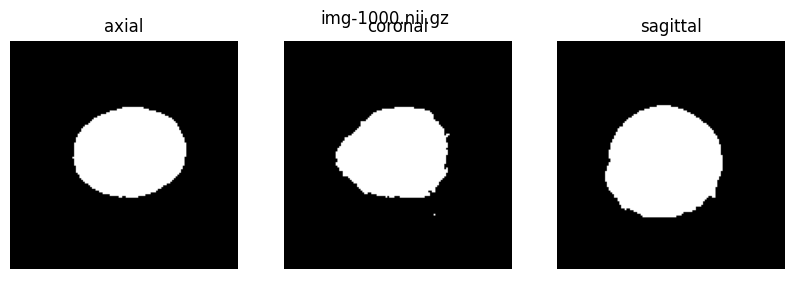

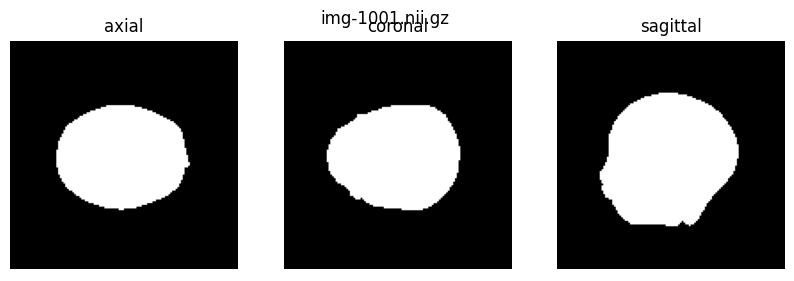

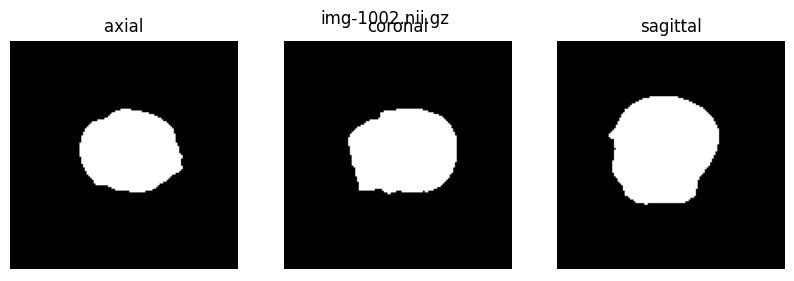

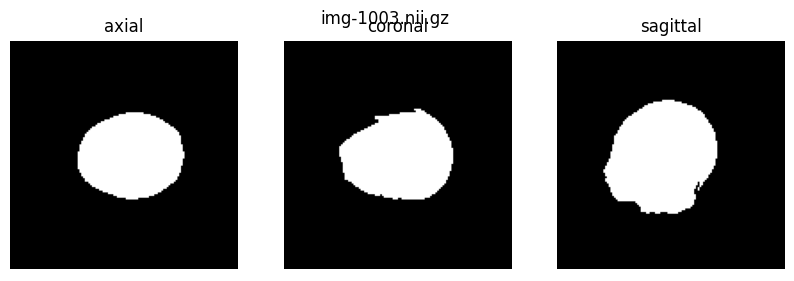

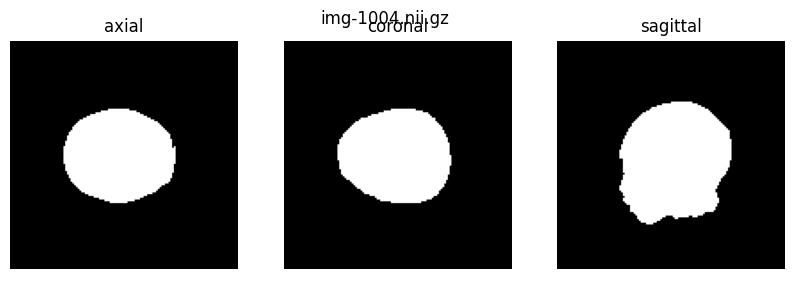

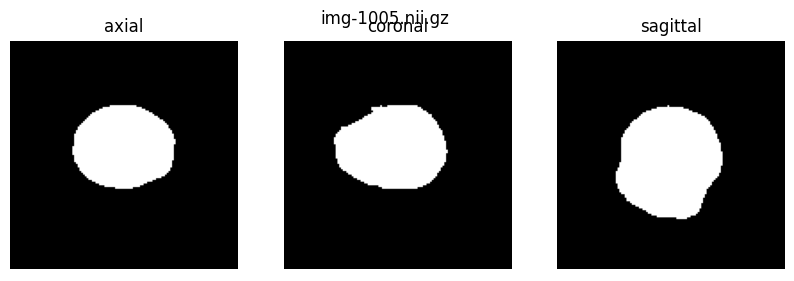

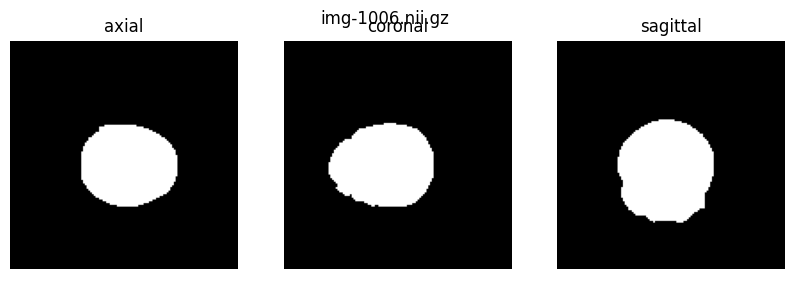

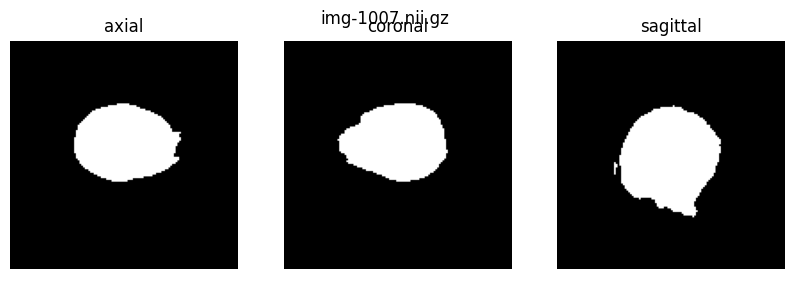

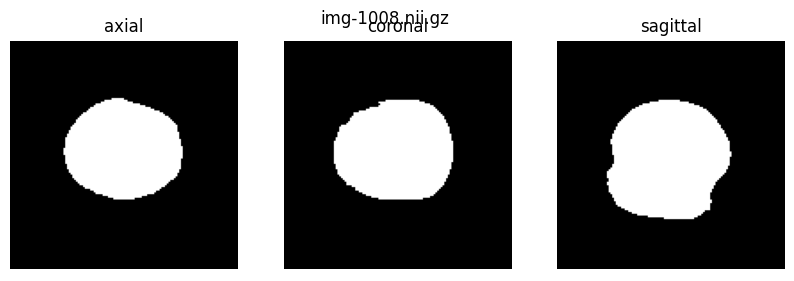

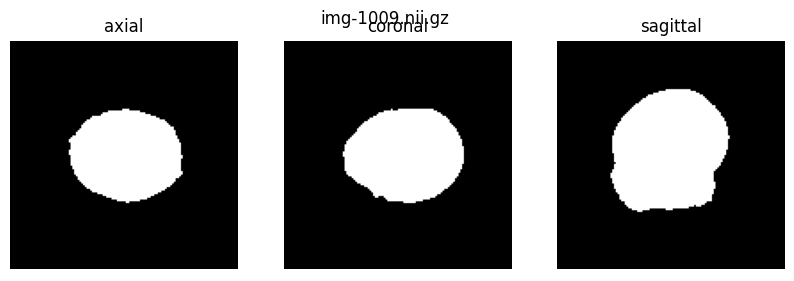

In [ ]:
for image, image_name in zip(vnet_no_aug_test_images, vnet_no_aug_test_images_name):
    Display3D(image, title=image_name)

In [ ]:
gt_dir = ('/content/drive/MyDrive/face-seg-project-2023/new-training-062023/face-test-subjects')

In [ ]:
gt_images = []
gt_images_name = []

test_file_numbers = ['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009']

# Create a dictionary to store the images and their corresponding numbers
image_dict = {}

# Iterate through all files in the directory
for filename in os.listdir(gt_dir):
    for number in test_file_numbers:
        if number in filename and filename.endswith('mask-'+ number +'.nii.gz'):
            full_file_path = os.path.join(gt_dir, filename)
            image = sitk.ReadImage(full_file_path)
            image_dict[number] = image

# Append the images in the order specified by val_file_numbers list
for number in test_file_numbers:
    if number in image_dict:
        gt_images.append(image_dict[number])
        gt_images_name.append(number + '-mask.nii.gz')
        print(f'Appended image {filename}')
    else:
        print(f'Warning: No image found for number {number}')



Appended image mask-1009.nii.gz
Appended image mask-1009.nii.gz
Appended image mask-1009.nii.gz
Appended image mask-1009.nii.gz
Appended image mask-1009.nii.gz
Appended image mask-1009.nii.gz
Appended image mask-1009.nii.gz
Appended image mask-1009.nii.gz
Appended image mask-1009.nii.gz
Appended image mask-1009.nii.gz


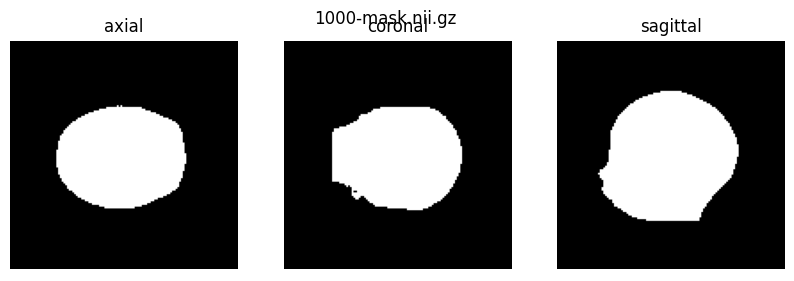

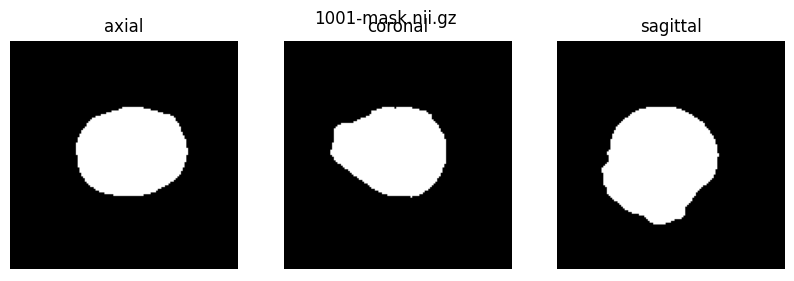

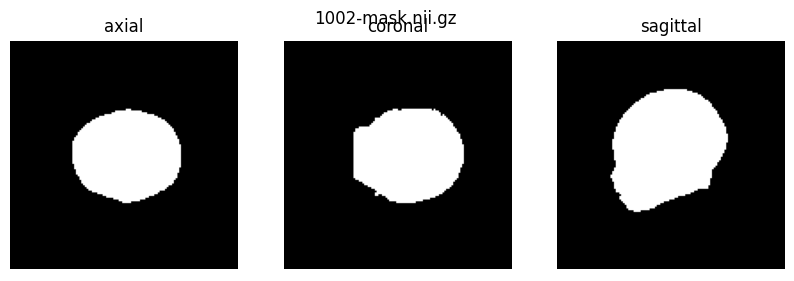

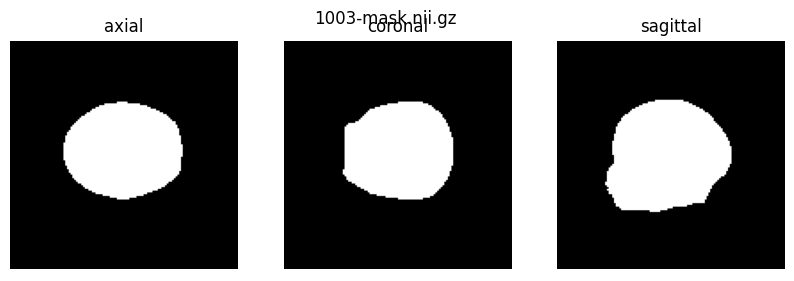

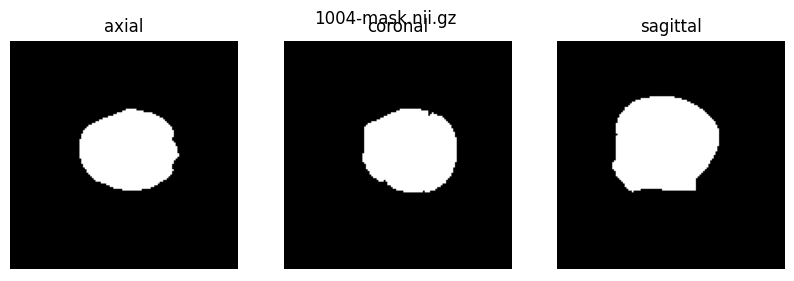

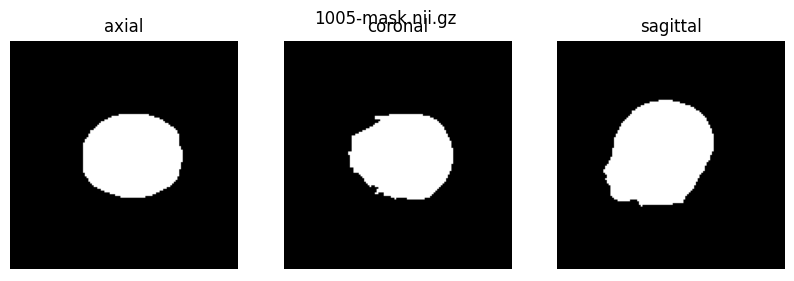

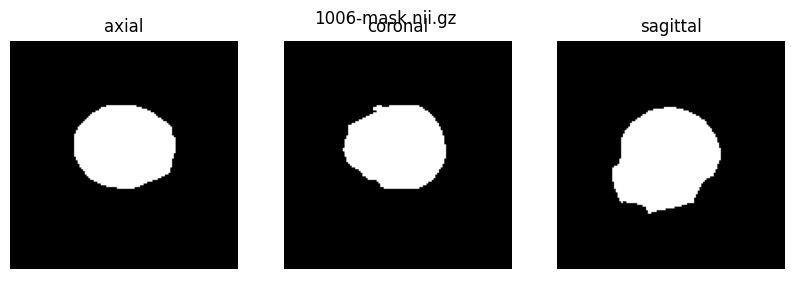

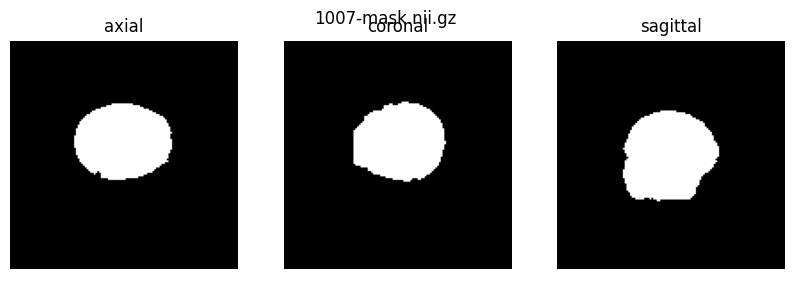

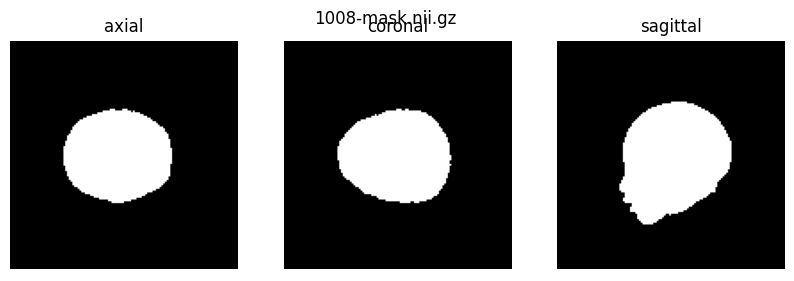

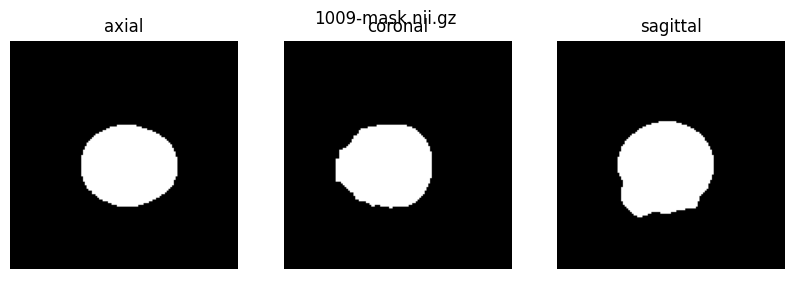

In [ ]:
for image, image_name in zip(gt_images, gt_images_name):
    Display3D(image, title=image_name)

In [ ]:


# Create a CastImageFilter instance
cast_filter = CastImageFilter()

dice_scores = []
haudorff_scores = []
avg_haudorff_scores = []
precision_scores = []
recall_scores = []




for (pred, gt), (pred_name, gt_name) in zip(zip(vnet_no_aug_test_images, gt_images), zip(vnet_no_aug_test_images_name, gt_images_name)):
    pred_array = sitk.GetArrayFromImage(pred)
    gt_array = sitk.GetArrayFromImage(gt)
    print(f"For predicted segmentation '{pred_name}' and ground truth segmentation '{gt_name}':")
    # Resample the predicted image to match the attributes of the ground truth
    pred_resampled = sitk.Resample(pred, gt, sitk.Transform(), sitk.sitkLinear, 0.0, pred.GetPixelIDValue())


    # Calculate Dice score
    dice_score = Dice(pred, gt)
    dice_scores.append(dice_score)

    # Cast the pixel type of one of the images to match the other
    if pred.GetPixelID() != gt.GetPixelID():
        if pred.GetPixelID() > gt.GetPixelID():
            cast_filter.SetOutputPixelType(pred.GetPixelID())
            gt = cast_filter.Execute(gt)
        else:
            cast_filter.SetOutputPixelType(gt.GetPixelID())
            pred = cast_filter.Execute(pred)

    # Calculate Hausdorff and average Hausdorff
    hausdorff_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_filter.Execute(pred_resampled, gt)
    hausdorff = hausdorff_filter.GetHausdorffDistance()

    average_hausdorff = hausdorff_filter.GetAverageHausdorffDistance()
    haudorff_scores.append(hausdorff)
    avg_haudorff_scores.append(average_hausdorff)

    # Calculate Precision and Recall score
    precision_score, recall_score = Precision_Recall(pred, gt)
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    print("\n")





# Calculate the mean Dice score
mean_dice_score = np.mean(dice_scores)
print("Mean Dice Score:", mean_dice_score)

# Calculate the mean hausdorff score
mean_hausdorff = np.mean(haudorff_scores)
print("Mean Hausdorff:", mean_hausdorff)

# Calculate the mean average hausdorff score
mean_avg_hausdorff = np.mean(avg_haudorff_scores)
print("Mean Average Hausdorff:", mean_avg_hausdorff)

# Calculate the mean precision score
mean_precision = np.mean(precision_scores)
print("Mean Precision: ", mean_precision)

# Calculate the mean recall score
mean_recall = np.mean(recall_scores)
print("Mean Recall: ", mean_recall)

print("\n")
print("\n")
print("\n")






For predicted segmentation 'img-1000.nii.gz' and ground truth segmentation '1000-mask.nii.gz':
Dice Score = 0.781965
Precision Score: 0.989024
Recall Score: 0.646596


For predicted segmentation 'img-1001.nii.gz' and ground truth segmentation '1001-mask.nii.gz':
Dice Score = 0.742962
Precision Score: 0.599013
Recall Score: 0.97798


For predicted segmentation 'img-1002.nii.gz' and ground truth segmentation '1002-mask.nii.gz':
Dice Score = 0.877941
Precision Score: 0.969727
Recall Score: 0.802027


For predicted segmentation 'img-1003.nii.gz' and ground truth segmentation '1003-mask.nii.gz':
Dice Score = 0.842111
Precision Score: 0.969366
Recall Score: 0.74439


For predicted segmentation 'img-1004.nii.gz' and ground truth segmentation '1004-mask.nii.gz':
Dice Score = 0.692509
Precision Score: 0.586868
Recall Score: 0.844532


For predicted segmentation 'img-1005.nii.gz' and ground truth segmentation '1005-mask.nii.gz':
Dice Score = 0.763604
Precision Score: 0.749139
Recall Score: 0.778